## Objective : predict healthcare cost using patients data

### data points:
     1. Patient ID - Unique patient identifier
     2. Age - Age of a patient
     3. BMI - Body mass index of a patient
     4. SmokingStatus - indicates whether patients smokes or not (Non-Smoker, Smoker)
     5. ChronicCondition - indication of chronic condition (Yes, No)
     6. AnnualCost - amount spent on a hospital to recover

### Import Standard Libraries

In [987]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score

### Read and Understand the data

In [782]:
costs = pd.read_csv("healthcare_costs.csv")
costs.head()

,PatientID,Age,BMI,SmokingStatus,ChronicCondition,AnnualCost
0,1001,58,37.0,Non-Smoker,Yes,6725.12
1,1002,71,33.1,Smoker,Yes,17359.16
2,1003,48,28.2,Smoker,Yes,7259.34
3,1004,34,18.8,Non-Smoker,Yes,12287.21
4,1005,62,38.8,Non-Smoker,Yes,8334.85


### Since, PatientID is just an identifier, it could be dropped from the dataset

In [784]:
costs = costs.drop('PatientID',axis=1)

### Exploratory Data Analysis

In [786]:
#check if there are any null values
costs.isna().sum().sort_values()

Age                 0
BMI                 0
SmokingStatus       0
ChronicCondition    0
AnnualCost          0
dtype: int64

In [787]:
#check for descriptive statistics
costs.describe()

,Age,BMI,AnnualCost
count,50.000000,50.000000,50.000000
mean,51.860000,29.260000,10081.385200
std,17.700467,6.101923,2575.747173
min,21.000000,18.800000,5150.220000
25%,40.000000,24.500000,8223.007500
50%,50.500000,29.900000,9978.370000
75%,67.500000,34.025000,11866.262500
max,79.000000,39.300000,17359.160000


In [788]:
#check for datatypes
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               50 non-null     int64  
 1   BMI               50 non-null     float64
 2   SmokingStatus     50 non-null     object 
 3   ChronicCondition  50 non-null     object 
 4   AnnualCost        50 non-null     float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.1+ KB


### Distribution of Age

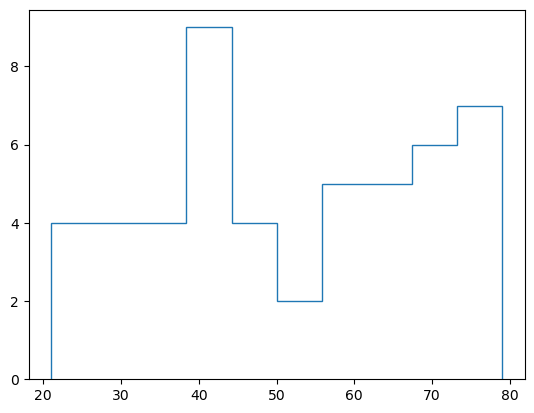

In [790]:
plt.hist('Age',data=costs,bins=10, histtype='step')
plt.show()

#### Age is not normally distributed

### Age Vs BMI

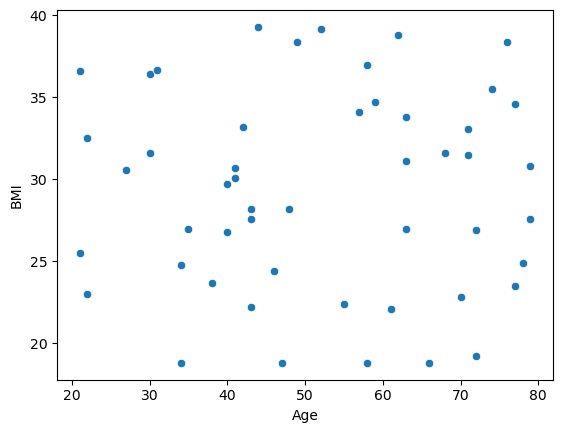

In [793]:
sns.scatterplot(x="Age",y="BMI", data=costs)
plt.show()

#### weekly correlated (no correlation)

### Age Vs Annual Cost (Hue = SmokingStatus)

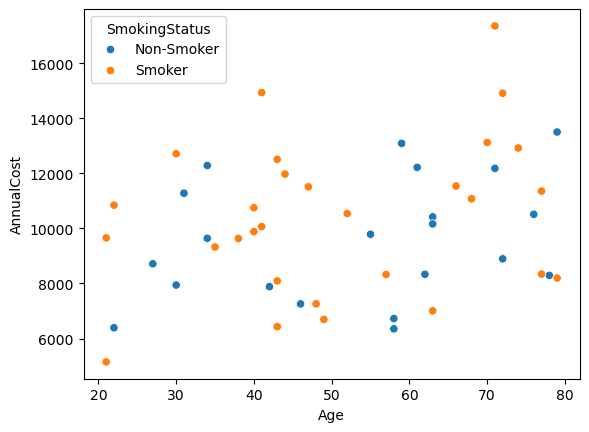

In [796]:
sns.scatterplot(x="Age",y="AnnualCost", hue='SmokingStatus', data=costs)
plt.show()

#### Slightly correlated with hue as SmokingStatus

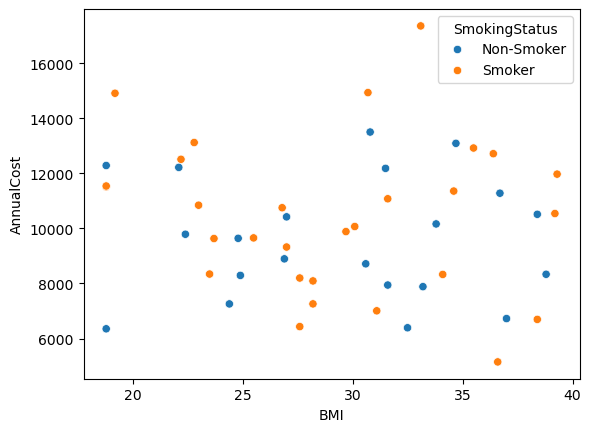

In [798]:
sns.scatterplot(x="BMI",y="AnnualCost",hue="SmokingStatus", data=costs)
plt.show()

#### there is no much of interpretation from the above graph

### Distribution of Smoking Status

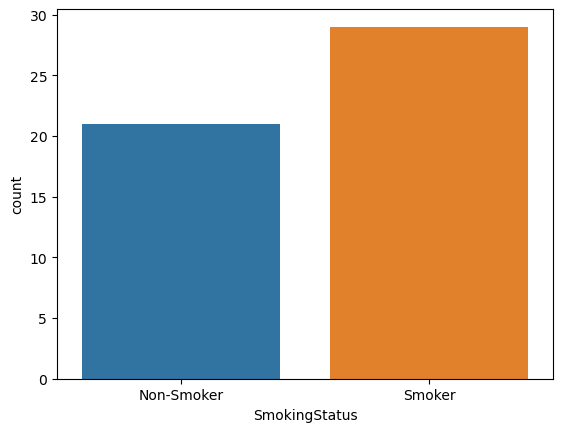

In [801]:
sns.countplot(data=costs,x="SmokingStatus", hue="SmokingStatus")
plt.show()

#### Distribution is not overly Skewed (Smokers are more compared to Non-Smokers)

### Distribution of ChronicCondtion

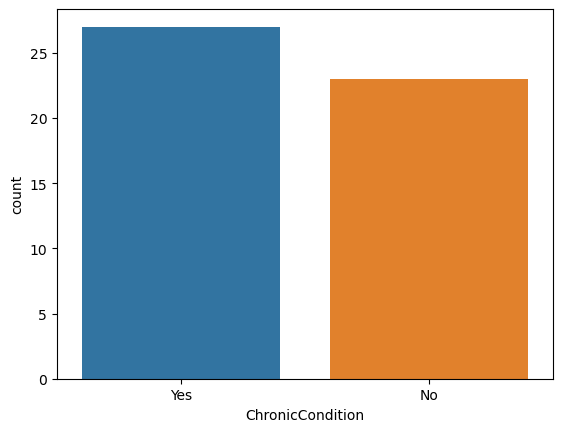

In [804]:
sns.countplot(data=costs,x="ChronicCondition",hue="ChronicCondition")
plt.show()

#### Distribution is not overly Skewed (Yes are more compared to No in ChronicCondition Feature)

### Box Plot -  Checkfor an outliers in AnnualCost(Target Variable)

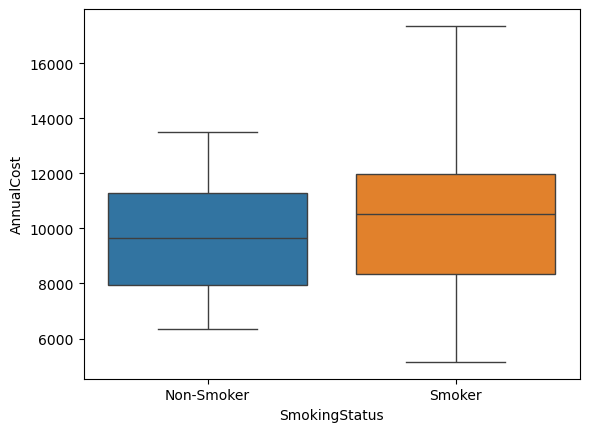

In [807]:
sns.boxplot(data=costs, x="SmokingStatus",y="AnnualCost",hue="SmokingStatus")
plt.show()

#### AnnualCost is more when SmokingStatus is a Smoker

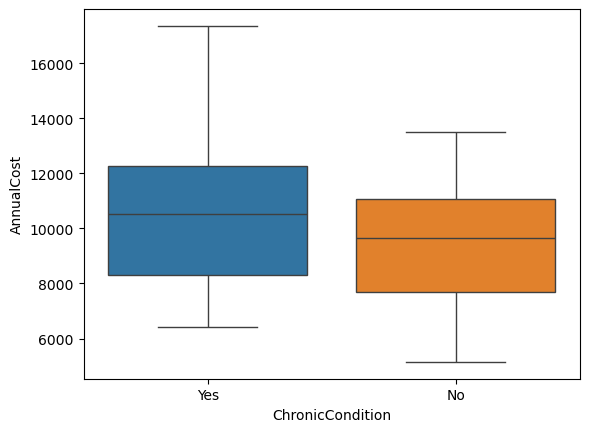

In [809]:
sns.boxplot(data=costs, x="ChronicCondition",y="AnnualCost",hue="ChronicCondition")
plt.show()

#### AnnualCost is more when ChronicCondition is a Yes

### Distribution between Age and ChronicCondition

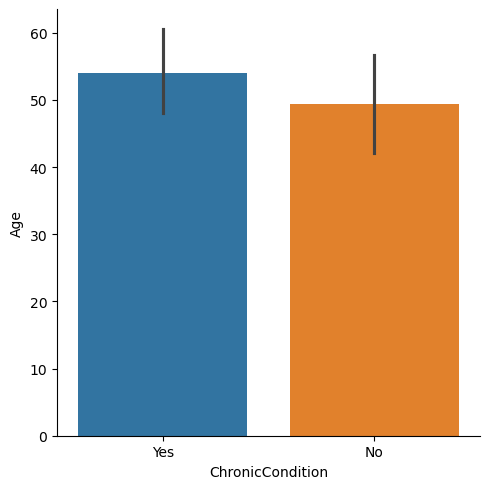

In [812]:
sns.catplot(data=costs, x="ChronicCondition", y="Age",kind="bar",hue="ChronicCondition")
plt.show()

#### ChronicCondtion occurs is more in aged patients

### Bi-Variate Analysis (How does SmokingCondition and ChronicCondtion Relate with AnnualCost

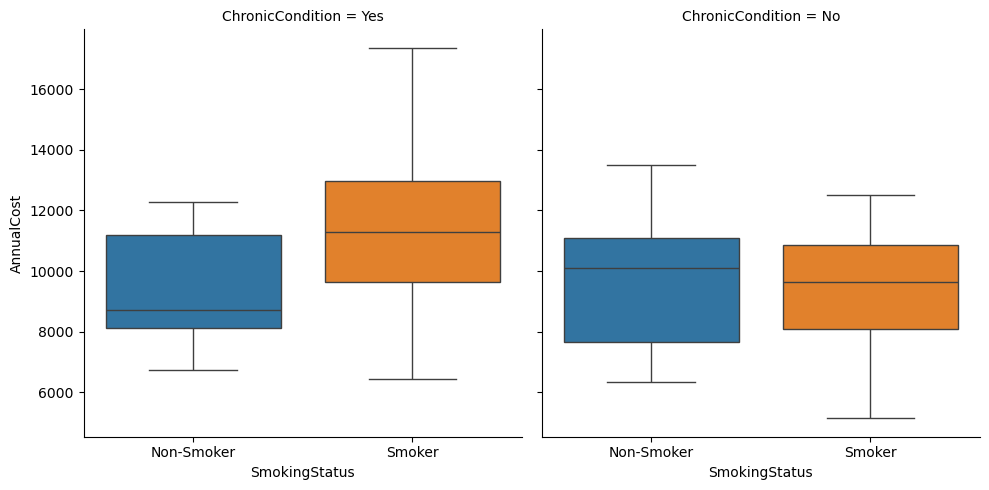

In [815]:
sns.catplot(data=costs, x="SmokingStatus",y="AnnualCost",col="ChronicCondition",kind="box",hue="SmokingStatus")
plt.show()

#### When there is a chronicConditon and Patient is a Smoker, The AnnualCost is more 

###### The median AnnualCost for patients with SmokingCondtion='Smoker' and ChronicCondtion='Yes' is more compared to patients with SmokingCondtion='Smoker' and ChronicCondtion='No'

### Statistics

In [818]:
#check for correlation
costs[['Age', 'BMI', 'AnnualCost']].corr()

,Age,BMI,AnnualCost
Age,1.000000,-0.006628,0.262913
BMI,-0.006628,1.000000,-0.092863
AnnualCost,0.262913,-0.092863,1.000000


#### There is no correlation between Age and BMI, but slight correlation between Age and AnnualCost

In [820]:
#check for multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd

X = sm.add_constant(costs[['Age', 'BMI']])  # include constant/intercept
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["feature"] = X.columns
print(vif)

         VIF feature
0  33.414076   const
1   1.000044     Age
2   1.000044     BMI


#### There is no multi-collinearity between Age and BMI since VIF is < 5

##### VIF checks whether your predictors are redundant or highly correlated with each other, which can hurt your model stability.

##### Target Variable(AnnualCost) Shouldn't be added as it will give invalid VIF

### Preprocessing the data

#### Check for an outliers in annual costs

In [824]:
#get the quantiles and iqr for annualcosts to remove an outlier

def remove_outliers(df,colname):
    seventy_fifth = np.quantile(df[colname],q=0.75)
    twenty_fifth = np.quantile(df[colname],q=0.25)
    iqr = seventy_fifth - twenty_fifth
    
    #get lower and upper boundaries
    lower = twenty_fifth - (1.5*iqr)
    upper = seventy_fifth + (1.5*iqr)
    
    costs = df[(df[colname] > lower) & (df[colname] < upper)]
    return costs

In [825]:
costs = remove_outliers(costs,'AnnualCost')
costs = remove_outliers(costs,'BMI')

In [826]:
#Feature Engineering to create Categories to train the model

def create_categories(col_name,new_col_name,labels):
    min_quantile = costs[col_name].min()
    twenty_fifth_quantile = np.quantile(a=costs[col_name],q=0.25)
    median_quantile = np.quantile(a=costs[col_name],q=0.50)
    seventy_fifth_quantile = np.quantile(a=costs[col_name],q=0.75)
    max_quantile = costs[col_name].max()
    
    bins = [0, min_quantile, twenty_fifth_quantile, median_quantile, seventy_fifth_quantile, max_quantile]
    print(bins)
    costs[new_col_name] = pd.cut(x=costs[col_name],bins=bins,labels=labels)

    return costs

In [827]:
costs = create_categories(col_name="AnnualCost", new_col_name="CostCat",labels=['Minimum','Least','Median','Upper-Median','Maximum'])
costs = create_categories(col_name="BMI", new_col_name="BMICat",labels=['L','ML','H','MH','VH'])
costs = create_categories(col_name='Age', new_col_name="AgeCat", labels=['Very-Young','Young-Adult','Middle-Aged','Late-Middle-Age','Senior'])

[0, 5150.22, 8199.26, 9886.49, 11542.51, 14936.43]
[0, 18.8, 24.4, 29.7, 34.1, 39.3]
[0, 21, 40.0, 49.0, 66.0, 79]


In [828]:
costs.head()

,Age,BMI,SmokingStatus,ChronicCondition,AnnualCost,CostCat,BMICat,AgeCat
0,58,37.0,Non-Smoker,Yes,6725.12,Least,VH,Late-Middle-Age
2,48,28.2,Smoker,Yes,7259.34,Least,H,Middle-Aged
3,34,18.8,Non-Smoker,Yes,12287.21,Maximum,L,Young-Adult
4,62,38.8,Non-Smoker,Yes,8334.85,Median,VH,Late-Middle-Age
5,27,30.6,Non-Smoker,Yes,8715.53,Median,MH,Young-Adult


#### BMICategories & SmokingStatus Vs AnnualCost

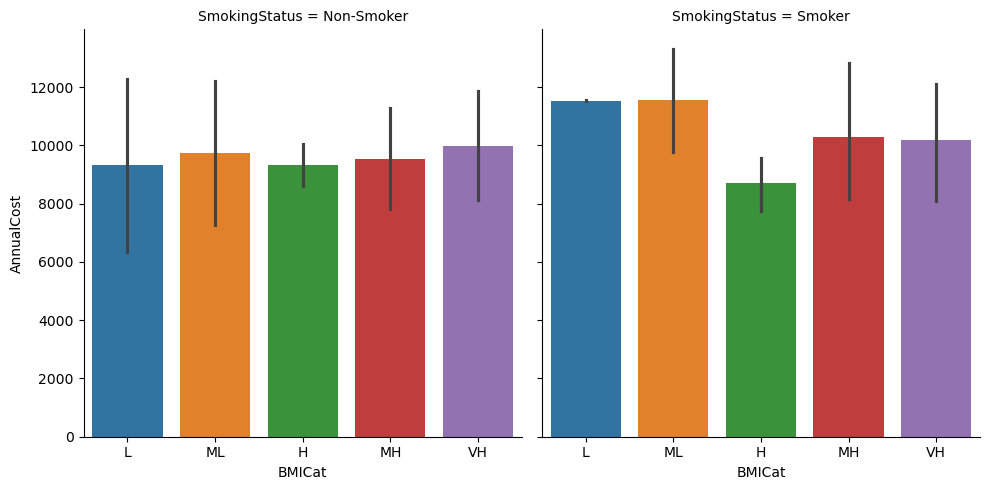

In [830]:
sns.catplot(data=costs, x="BMICat", y="AnnualCost",col="SmokingStatus",kind="bar",hue="BMICat")
plt.show()

###### AnnualCost is lower for patients with ‘H’ BMI across both Non-Smokers and Smokers.
###### AnnualCost is higher for patients with ‘VH’ and ‘L’ BMI among both Non-Smokers and Smokers.

#### BMICategories & AgeCategories Vs AnnualCost

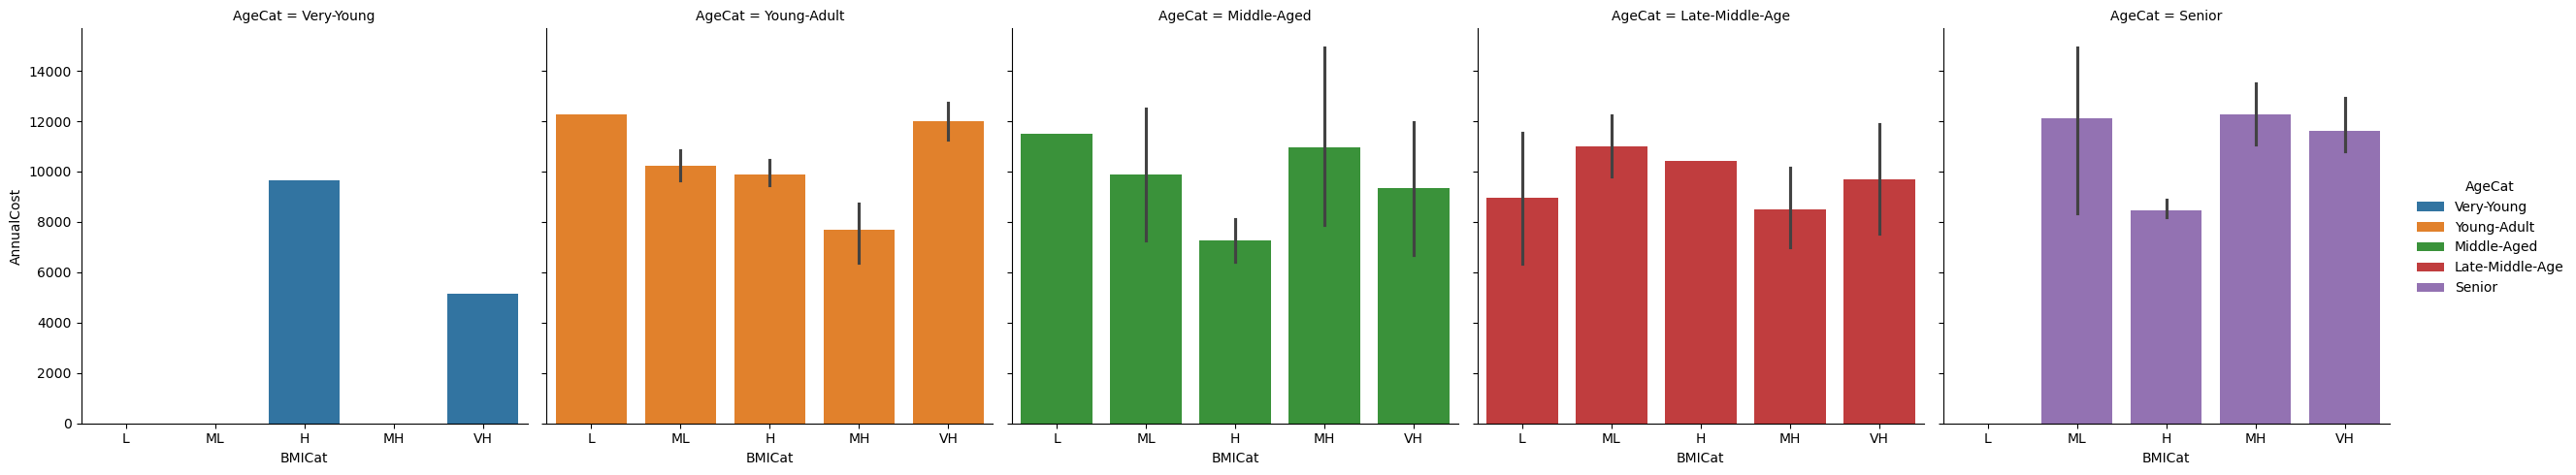

In [833]:
sns.catplot(data=costs, x="BMICat", y="AnnualCost",col="AgeCat",kind="bar",hue="AgeCat")
plt.show()

##### No Data: BMICategories 'L', 'ML', 'MH' for AgeCategories 'Very-Young' / BMICategories 'L' for AgeCategories 'Senior'

###### AnnualCost is highest for 'H' BMI category among Very Young, while 'VH' incurs the lowest.
###### AnnualCost is highest for 'L' and 'VH' BMI categories among Young Adults, while 'MH' incurs the lowest.
###### AnnualCost is highest for 'L' and 'MH' BMI categories among Middle-Aged individuals, while 'H' incurs the lowest.
###### AnnualCost is highest for 'ML' and 'VH' BMI categories among Late Middle-Aged individuals, while 'MH' incurs the lowest.
###### AnnualCost is highest for 'MH' and 'ML' BMI categories among Seniors, while 'H' incurs the lowest.

#### BMICategories & AgeCategories Vs AnnualCost

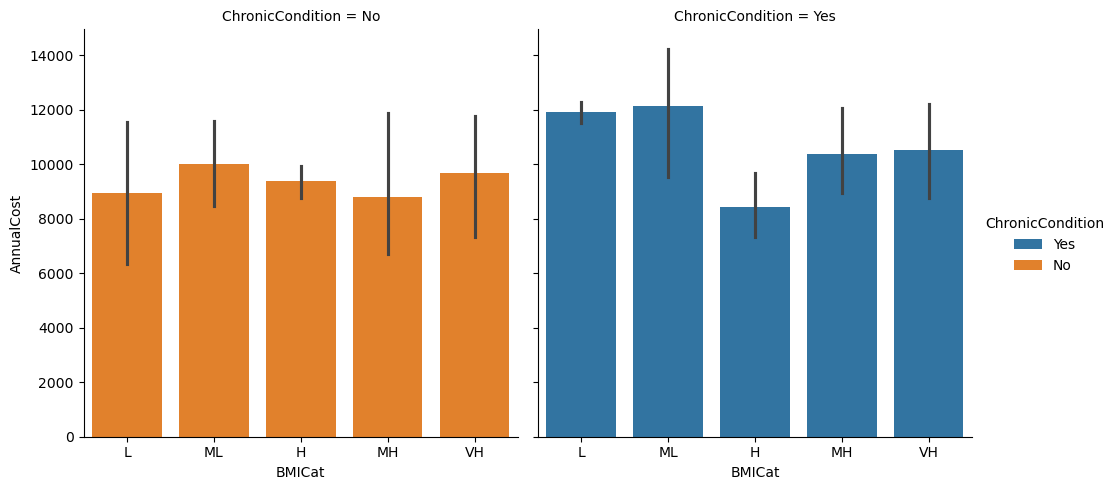

In [837]:
sns.catplot(data=costs, x="BMICat", y="AnnualCost",col="ChronicCondition",kind="bar",hue="ChronicCondition",col_order=['No','Yes'])
plt.show()

###### AnnualCost is high for ‘L’/‘ML’ without Chronic Conditions, and ‘ML’/‘VH’ with Chronic Conditions.
###### Annual cost is low for 'MH' without Chronic Conditions, and 'H' with Chronic Conditions.

#### Converting Categorical to numerical data

In [840]:
costs = pd.get_dummies(costs,columns=['SmokingStatus','ChronicCondition','CostCat','BMICat','AgeCat'],drop_first=True,dtype=int)
costs.head()

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,BMICat_H,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior
0,58,37.0,6725.12,0,1,1,0,0,0,0,0,0,1,0,0,1,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,1,0,0,0,1,0,0
3,34,18.8,12287.21,0,1,0,0,0,1,0,0,0,0,1,0,0,0
4,62,38.8,8334.85,0,1,0,1,0,0,0,0,0,1,0,0,1,0
5,27,30.6,8715.53,0,1,0,1,0,0,0,0,1,0,1,0,0,0


### Machine Learning Model (Regression)

#### Linear Regression 

In [1070]:
X = costs.drop(['Age','BMI','AnnualCost'],axis=1).values
y = costs['AnnualCost'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

lin_r2_score = r2_score(y_test,y_pred)

#### Ridge Regression

In [1066]:
scores_rid = []

for alpha in [0.1,1.0,10.0,100.0,1000.0]:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train,y_train)
    y_pred_rid = ridge.predict(X_test)
    
    scores_rid.append(ridge.score(X_test,y_test))
scores_rid

[0.6566577213294196,
 0.6958676936354212,
 0.3924359975819549,
 -0.24046929452235832,
 -0.4176032902467288]

In [905]:
kf = KFold(n_splits=4,shuffle=True,random_state=42)
param_grid = {
                'alpha':np.arange(0.0001,1,10),
                'solver':["sag","lsqr"]
        }

ridge = Ridge()
ridge_cv = GridSearchCV(estimator=ridge,param_grid=param_grid,cv=kf)
ridge_cv.fit(X_train,y_train)
print(ridge_cv.best_params_, ridge_cv.best_score_)

{'alpha': 0.0001, 'solver': 'lsqr'} 0.6998302685930458


In [911]:
test_score = ridge_cv.score(X_test,y_test)
test_score

0.6245015484394709

In [1072]:
rid_best_model = ridge_cv.best_estimator_
rid_best_model.fit(X_train,y_train)
y_pred_rid_best = rid_best_model.predict(X_test)
rid_r2_score = r2_score(y_test,y_pred_rid_best)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.546e+05, tolerance: 2.054e+04
  model = cd_fast.enet_coordinate_descent(


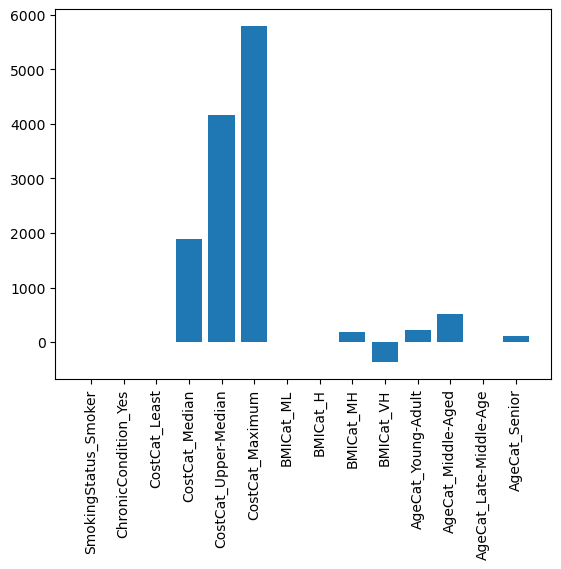

In [887]:
scores_las = []
for alpha in [0.1,1.0,10.0,20.0,50.0]:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred_las = lasso.predict(X_test)
    scores_las.append(lasso.score(X_test,y_test))
scores_las

col_names = costs.drop(['Age','BMI','AnnualCost'],axis=1).columns

lasso = Lasso(alpha=10.0)
lasso_coef = lasso.fit(X_train,y_train).coef_
plt.bar(col_names, lasso_coef)
plt.xticks(rotation=90)
plt.show()

#### Decision Tree Regressor

In [956]:
kf_dt = KFold(n_splits=4,shuffle=True,random_state=42)
param_grid_dt = {
                'max_depth':np.arange(1,10,1),
                'min_samples_leaf':[1,2,4,6,8,10,20],
                'random_state':[42]
        }

dt = DecisionTreeRegressor(random_state=42)
dt_cv = GridSearchCV(estimator=dt,param_grid=param_grid_dt,cv=kf_dt)
dt_cv.fit(X_train,y_train)
print(dt_cv.best_params_, dt_cv.best_score_)

{'max_depth': 3, 'min_samples_leaf': 2} 0.7806295093800883


In [958]:
test_score_dt = dt_cv.score(X_test,y_test)
test_score_dt

0.7857309827378014

In [1078]:
dt_best_model = dt_cv.best_estimator_
dt_best_model.fit(X_train,y_train)
y_pred_dt_best = dt_best_model.predict(X_test)
dt_r2_score = r2_score(y_test,y_pred_dt_best)

#### RandomForest Regressor

In [1007]:
kf_rf = KFold(n_splits=4,shuffle=True,random_state=42)
param_grid_rf = {
                'max_depth':np.arange(1,10,1),
                'min_samples_leaf': [1,2,4,6,8,10,20],
                'n_estimators': [100,200,300,500],
        }

rf = RandomForestRegressor(random_state=42)
rf_cv = GridSearchCV(estimator=rf,param_grid=param_grid_rf,cv=kf_rf)
rf_cv.fit(X_train,y_train)
print(rf_cv.best_params_, rf_cv.best_score_)

{'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 500} 0.7273287050575712


In [1015]:
test_score_rf = rf_cv.score(X_test,y_test)
test_score_rf

0.7730938270498591

In [1080]:
rf_best_model = rf_cv.best_estimator_
rf_best_model.fit(X_train,y_train)
y_pred_rf_best = rf_best_model.predict(X_test)
rf_r2_score = r2_score(y_test,y_pred_rf_best)

#### AdaBoost Regressor

In [1022]:
kf_ad = KFold(n_splits=4,shuffle=True,random_state=42)
param_grid_ad = {
                'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0],
                'n_estimators': [100,200,300,500],
                'random_state':[42]
        }

ad = AdaBoostRegressor(random_state=42)
ad_cv = GridSearchCV(estimator=ad,param_grid=param_grid_ad,cv=kf_ad)
ad_cv.fit(X_train,y_train)
print(ad_cv.best_params_, ad_cv.best_score_)

{'learning_rate': 0.01, 'n_estimators': 500, 'random_state': 42} 0.6915848329791274


In [1024]:
test_score_ad = ad_cv.score(X_test,y_test)
test_score_ad

0.7788829940942299

In [1082]:
ad_best_model = ad_cv.best_estimator_
ad_best_model.fit(X_train,y_train)
y_pred_ad_best = ad_best_model.predict(X_test)
ada_r2_score = r2_score(y_test,y_pred_ad_best)

#### GradientBoosting Regressor

In [1031]:
kf_gb = KFold(n_splits=4,shuffle=True,random_state=42)
param_grid_gb = {
                'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators': [100,200,300,500],
                'random_state':[42],
                'max_depth':np.arange(1,5,1),
                'min_samples_leaf': [1,2,4,6,8,10,20]
        }

gb = GradientBoostingRegressor(random_state=42)
gb_cv = GridSearchCV(estimator=gb,param_grid=param_grid_gb,cv=kf_gb)
gb_cv.fit(X_train,y_train)
print(gb_cv.best_params_, gb_cv.best_score_)

{'learning_rate': 0.05, 'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 42} 0.775126853041687


In [1033]:
test_score_gb = gb_cv.score(X_test,y_test)
test_score_gb

0.792656836730765

In [1084]:
gb_best_model = gb_cv.best_estimator_
gb_best_model.fit(X_train,y_train)
y_pred_gb_best = gb_best_model.predict(X_test)
gb_r2_score = r2_score(y_test,y_pred_gb_best)

#### Stochastic GradientBoosting

In [1048]:
kf_sgb = KFold(n_splits=4,shuffle=True,random_state=42)
param_grid_sgb = {
                'learning_rate': [0.01, 0.05, 0.1],
                'subsample':np.linspace(0.1,0.8,8),
                'n_estimators': [100,200,300,500],
                'max_features':[0.1,0.2,0.3,0.4,0.5],
                'random_state':[42],
                'max_depth':np.arange(1,5,1),
                'min_samples_leaf': [1,2,4,6,8,10,20]
        }

sgb = GradientBoostingRegressor(random_state=42)
sgb_cv = GridSearchCV(estimator=sgb,param_grid=param_grid_sgb,cv=kf_sgb)
sgb_cv.fit(X_train,y_train)
print(sgb_cv.best_params_, sgb_cv.best_score_)

{'learning_rate': 0.1, 'max_depth': 1, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 500, 'random_state': 42, 'subsample': 0.2} 0.7515144567588914


In [1050]:
test_score_sgb = sgb_cv.score(X_test,y_test)
test_score_sgb

0.7574058997364855

In [1086]:
sgb_best_model = sgb_cv.best_estimator_
sgb_best_model.fit(X_train,y_train)
y_pred_sgb_best = sgb_best_model.predict(X_test)
sgb_r2_score = r2_score(y_test,y_pred_sgb_best)

In [1092]:
r2_scores = pd.DataFrame({'models':['lin_reg','ridge_reg','decisionT','RandomF','AdaBoost','GradientBoost','StochGradBoost'],
            'R2_scores':[lin_r2_score,rid_r2_score,dt_r2_score,rf_r2_score,ada_r2_score,gb_r2_score,sgb_r2_score]})

In [1178]:
r2_scores.sort_values(by='R2_scores',ascending=False)

list(r2_scores['models'])

['lin_reg',
 'ridge_reg',
 'decisionT',
 'RandomF',
 'AdaBoost',
 'GradientBoost',
 'StochGradBoost']

In [1128]:
param_grids = {
                'Ridge': {
                    'alpha':np.arange(0.0001,1,10),
                    'solver':["sag","lsqr"]
                         }, 
               'DecisionTree':{
                   'max_depth':np.arange(1,10,1),
                   'min_samples_leaf':[1,2,4,6,8,10,20],
                   'random_state':[42]
               },
               'RandomForest':{
                   'max_depth':np.arange(1,10,1),
                   'min_samples_leaf': [1,2,4,6,8,10,20],
                   'n_estimators': [100,200,300,500],
                   'random_state':[42]
               },
               'AdaBoost':{
                   'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0],
                   'n_estimators': [100,200,300,500],
                   'random_state':[42]  
               },
               'GradientBoosting':{
                   'learning_rate': [0.01, 0.05, 0.1],
                   'n_estimators': [100,200,300,500],
                   'random_state':[42],
                   'max_depth':np.arange(1,5,1),
                   'min_samples_leaf': [1,2,4,6,8,10,20]
               },
               'SGD':{
                   'learning_rate': [0.01, 0.05, 0.1],
                   'subsample':np.linspace(0.1,0.8,8),
                   'n_estimators': [100,200,300,500],
                   'max_features':[0.1,0.2,0.3,0.4,0.5],
                   'random_state':[42],
                   'max_depth':np.arange(1,5,1),
                   'min_samples_leaf': [1,2,4,6,8,10,20]
               }}

### Utility Function

In [1184]:
def Model_Training(X_train, y_train, X_test, y_test, model_names, param_grids=None):
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(),
        'DecisionTree': DecisionTreeRegressor(),
        'RandomForest': RandomForestRegressor(),
        'AdaBoost': AdaBoostRegressor(),
        'GradientBoosting': GradientBoostingRegressor(),
        'SGD': GradientBoostingRegressor()
    }

    results = []

    for model_name in model_names:
        model = models.get(model_name)
        print(model_name)
        if model is None:
            print(f"Model '{model_name}' not recognized. Skipping.")
            continue


        # If model has no parameters or not in param_grids - direct fit
        if param_grids is None or model_name not in param_grids:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)

            results.append({
                'Model': model_name,
                'BestParams': None,
                'CV_R2_Score': None,
                'Test_R2_Score': r2
            })
        else:
            param_grid = param_grids[model_name]
            kf = KFold(n_splits=4, shuffle=True, random_state=42)
            grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf)
            grid.fit(X_train, y_train)

            best_model = grid.best_estimator_
            best_cv_r2 = grid.best_score_
            test_r2 = r2_score(y_test, best_model.predict(X_test))

            results.append({
                'Model': model_name,
                'BestParams': grid.best_params_,
                'CV_R2_Score': best_cv_r2,
                'Test_R2_Score': test_r2
            })

    return pd.DataFrame(results)

In [ ]:
X = costs.drop(['Age','BMI','AnnualCost'],axis=1).values
y = costs['AnnualCost'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

results_df = Model_Training(X_train, y_train, X_test, y_test, model_names=['LinearRegression','Ridge','DecisionTree',
                                                                           'RandomForest','AdaBoost','GradientBoosting','SGD'], 
                            param_grids=param_grids)

results_df

LinearRegression
Ridge
DecisionTree
RandomForest
AdaBoost
GradientBoosting
SGD
